In [1]:
#경고 끄기
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='Malgun Gothic')

In [3]:
def getData():
    df2008 = pd.read_csv("C:/농수산가격데이터/1001배추/2008010120081231.csv")
    df2009 = pd.read_csv("C:/농수산가격데이터/1001배추/2009010120091231.csv")
    df2010 = pd.read_csv("C:/농수산가격데이터/1001배추/2010010120101231.csv")
    df2011 = pd.read_csv("C:/농수산가격데이터/1001배추/2011010120111231.csv")
    df2012 = pd.read_csv("C:/농수산가격데이터/1001배추/2012010120121231.csv")
    df2013 = pd.read_csv("C:/농수산가격데이터/1001배추/2013010120131231.csv")
    df2014 = pd.read_csv("C:/농수산가격데이터/1001배추/2014010120141231.csv")
    df2015 = pd.read_csv("C:/농수산가격데이터/1001배추/2015010120151231.csv")
    df2016 = pd.read_csv("C:/농수산가격데이터/1001배추/2016010120161231.csv")
    df2017 = pd.read_csv("C:/농수산가격데이터/1001배추/2017010120171231.csv")
    df2018 = pd.read_csv("C:/농수산가격데이터/1001배추/2018010120181231.csv")
    return pd.concat((df2008, df2009, df2010, df2011, df2012, df2013, df2014, df2015, df2016, df2017, df2018), axis=0)

In [4]:
def priceTransform(df):
    #Kg당 가격(priceperkg)
    #총거래가격(totalprice) = 거래량(delngQy) * 가격(sbidpric)
    #총량(totalweight) = 거래단량(delngprut) * 거래량(delngQy) * 단위

    df11 = df[(df['stdunitnewcode']==11)]
    df12 = df[(df['stdunitnewcode']==12)]
    df13 = df[(df['stdunitnewcode']==13)]
    df11['priceperkg'] = df11['sbidpric'] / df11['delngprut'] * 1000
    df11['totalweight'] = df11['delngprut'] * df11['delngqy'] / 1000
    df12['priceperkg'] = df12['sbidpric'] / df12['delngprut']
    df12['totalweight'] = df12['delngprut'] * df12['delngqy']
    df13['priceperkg'] = df13['sbidpric'] / df13['delngprut'] / 1000
    df13['totalweight'] = df13['delngprut'] * df13['delngqy'] * 1000
    
    df = pd.concat([df11, df12, df13])

    df['totalprice'] = df['sbidpric'] * df['delngqy']
        
    return df

In [5]:
df = getData()

In [6]:
df = priceTransform(df)

In [7]:
# aucsecode
# 경매 데이터 1 
# 수의계약 데이터 2

# 11,특
# 12,상
# 13,보통
# 1Z,무등급
# df = df[(df['stdqlitynewcode'] == '11')
#     | (df['stdqlitynewcode'] == '12')]

# 100101,봄배추
# 100102,여름배추
# 100103,김장(가을)배추
# 100104,월동배추
# 100105,고냉지배추
# 100106,저장배추

# 데이터 가공
# 가격이 100이하 제거
df = df[(df['priceperkg'] >= 100)]

# 근거자료
# https://www.kamis.or.kr/customer/main/main.do
# kamis1001[kamis1001['avg'] < 3000]
# 무게가 0인 것 제거
df = df[(df['totalweight'] > 0)]

df = df[
    (df['aucsecode'] == 1)
    & (
        (df['stdqlitynewcode'] == '11')
        | (df['stdqlitynewcode'] == '12')
    )
    & (
        (df['stdspciesnewcode'] == 100101)
            | (df['stdspciesnewcode'] == 100102)
            | (df['stdspciesnewcode'] == 100103)
            | (df['stdspciesnewcode'] == 100104)
            | (df['stdspciesnewcode'] == 100105)
            | (df['stdspciesnewcode'] == 100106)
    )
    & (
        (df['whsalmrktcode'] == 110001)
            | (df['whsalmrktcode'] == 210001)
            | (df['whsalmrktcode'] == 220001)
      )]

In [8]:
kamis1001 = pd.read_csv(r'C:\crop_data\1001kamis.csv')

In [9]:
# kamis 데이터는 10kg기준이라 kg 단위에서 * 10해줌
df['priceper10kg'] = df['priceperkg'].apply(lambda x: x*10)

In [10]:
# kamis 데이터를 기준으로 +-30%오차 이상인것은 제외했음
def deleteAnomalyPrice(priceper10kg, delngde):
    if(kamis1001[kamis1001['date'] == delngde]['avg'].shape[0]):
        kamis_price = kamis1001[kamis1001['date'] == delngde]['avg'].values[0]
        if((kamis_price*0.7 <= priceper10kg) & (priceper10kg <= kamis_price*1.3)):
            return 1
    return 0

In [11]:
df['normal'] = df[['priceper10kg','delngde']].apply(lambda x: deleteAnomalyPrice(x['priceper10kg'], x['delngde']), axis=1)

In [12]:
df['yyyy']   = df['delngde'].apply(lambda x: str(x)[0:4])
df['yyyymm'] = df['delngde'].apply(lambda x: str(x)[0:6])
df['delngde'] = df['delngde'].apply(lambda x: int(x))
df['yyyy']   = df['yyyy'].apply(lambda x: int(x))
df['yyyymm'] = df['yyyymm'].apply(lambda x: int(x))
# 정렬
df = df.sort_values(["delngde"], ascending=[True])

In [13]:
# kamis데이터 오차범위 내 컬럼만 남김
df = df[(df['normal'] == 1)]

In [14]:
df.to_csv('processed.csv')

In [15]:
new_df = pd.concat((df[['priceperkg','yyyymm']].groupby(['yyyymm']).mean(), df.groupby(['yyyymm'])[['totalprice','totalweight']].sum()), axis=1)

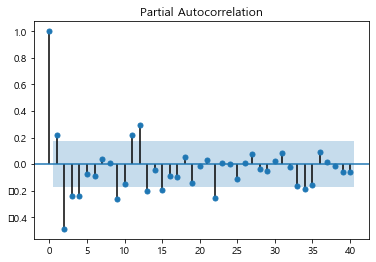

In [16]:
# 자기상관계수 확인
x_t  = new_df['priceperkg'][1:]
x_t1 = new_df['priceperkg'][:-1]
y = np.log(x_t.values / x_t1.values)
sm.graphics.tsa.plot_pacf(y, lags=40)
plt.show()

In [17]:
x_t1 = pd.Series(x_t1.values)
x_t = pd.Series(x_t.values)
x_t1.corr(x_t)

0.6316990660861077

In [18]:
new_df.to_csv('mean_of_month.csv')